In [279]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [399]:
class Layer(object):
    """define a layer object"""
    
    def __init__(self, n_input, n_output=None, low=-0.5, high=0.5, random_seed=42):
        """Constructer of a layer object"""
        
        self.n_input = n_input
        self.n_output = n_output
        
        np.random.seed(random_seed)
        self.weights = np.random.uniform(low, high, size=(self.n_input, self.n_output))

    def _sigmoid_forward(self, x):
        """Apply sigmoid function"""
        
        return 1 / (1 + np.exp(-x))
    
    def _tanh_forward(self, x):
        """Apply tanh function"""
        
        return (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
    
    def forward_prop(self, input_x, activation_func='sigmoid', add_noise=False):
        """Implement forward propagation"""
        
        # add noises to input
        if add_noise:
            input_x += np.random.uniform(-0.13, 0.13, size=input_x.shape)
        
        if activation_func == 'sigmoid':
            self.out_x = self._sigmoid_forward(input_x.dot(self.weights))
        elif activation_func == 'tanh':
            self.out_x = self._tanh_forward(input_x.dot(self.weights))

    def backward_prop(self, x_pre, delta_next, weights_next, eta, activation_func='sigmoid'):
        """Implement backward propagation"""
        
        if activation_func == 'sigmoid':
            self.delta = self.out_x * (1-self.out_x) * delta_next.dot(weights_next.T)
        elif activation_func == 'tanh':
            self.delta = (1 - np.square(self._tanh_forward(self.out_x))) * delta_next.dot(weights_next.T)
        
        self.weights -= eta * x_pre.T.dot(self.delta) / x_pre.shape[0]
    
class Softmax_Layer(Layer):
    """define a output layer object"""
    
    def __init__(self, n_input, n_output=None, low=-0.5, high=0.5, random_seed=42):
        """Constructer of a output layer object"""
            
        Layer.__init__(self, n_input, n_output, low, high, random_seed)
    
    def _softmax(self, out_x):
        return np.exp(out_x) / np.sum(np.exp(out_x))
    
    def _normalize(self, x):
        return (x - np.min(x)) / (np.max(x) - np.min(x))
        
    def forward_prop(self, input_x, normalize=False):
        """Implement forward propagation"""
        
        self.out_x = input_x.dot(self.weights)
        
        if normalize:
            self.out_x = np.apply_along_axis(self._normalize, 1, self.out_x)
                 
    def backward_prop(self, y_true, y_preds, x_pre, eta):
        """Implement backward propagation (output layer)"""
        
        self.delta = 2 * (y_preds - y_true)
        
        self.weights -= eta * x_pre.T.dot(self.delta) / x_pre.shape[0]
    
    def predict(self):
        """Predict labels"""
        
        self.pred_proba = np.apply_along_axis(self._softmax, 1, self.out_x)
        return (self.pred_proba == self.pred_proba.max(axis=1)[:, None]).astype(int)
    
    def compute_mse(self, y_true):
        """Compute mean square error"""
        
        return np.mean(np.square(self.out_x - y_true))
    
    def compute_miscla_rate(self, y_true):
        """Compute misclassification rate"""
        
        return 1 - np.sum(np.all(output_layer.predict() == y_true, axis=1)) / y_true.shape[0]

## Task 1

In [157]:
X = np.array([[1, 0, 0], [1, 1, 0], [1, 0, 1], [1, 1, 1]])
y = np.array([[0, 1], [1, 0], [1, 0], [0, 1]])

In [158]:
epochs = 10000
n_neurons = 2
fc_layer = Layer(X.shape[1], n_neurons)
output_layer = Softmax_Layer(n_neurons, 2)

In [159]:
errors = np.zeros(epochs)
for epoch in range(epochs):
    fc_layer.forward_prop(X)
    output_layer.forward_prop(fc_layer.out_x)
    
    y_preds = output_layer.predict()
    output_layer.backward_prop(y, y_preds, x_pre=fc_layer.out_x, eta=0.035)
    fc_layer.backward_prop(x_pre=X, delta_next=output_layer.delta, weights_next=output_layer.weights, eta=0.035)
    
    errors[epoch] = output_layer.compute_mse(y)

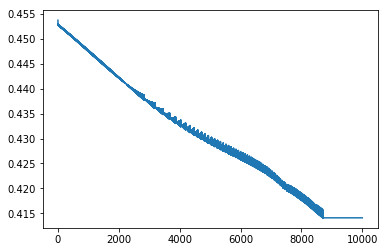

In [160]:
plt.plot(errors)

## Bonus Task

In [400]:
# load data
X = np.loadtxt('input/mfeat-pix.txt')

# add bias term
X = np.column_stack([np.ones(X.shape[0]), X])

# normalize data
# X = (X - np.min(X)) / (np.max(X) - np.min(X))

# split the dataset into training data and test data
train_indices = [range(0 + 200*i, 100 + 200*i) for i in range(10)]
test_indices = [range(100 + 200*i, 200 + 200*i) for i in range(10)]

X_train = X[train_indices, ].reshape(1000, 241)
X_test = X[test_indices, ].reshape(1000, 241)

In [401]:
# create class labels
nb_classes = 10
y_vector = np.array([i for i in range(10) for j in range(100)])
y_matrix = np.eye(nb_classes)[y_vector]

In [402]:
# set the architecture
epochs = 10000
neurons_1 = 256
neurons_2 = 128
fc_layer1 = Layer(X.shape[1], neurons_1, -0.43, 0.43)
fc_layer2 = Layer(neurons_1,neurons_2, -0.39, 0.39)
output_layer = Softmax_Layer(neurons_2, 10, -0.51, 0.51,)

train_mis = np.zeros(epochs)
test_mis = np.zeros(epochs)

In [403]:
for epoch in range(epochs):
    fc_layer1.forward_prop(X_train, activation_func='tanh', add_noise=True)
    fc_layer2.forward_prop(fc_layer1.out_x, activation_func='tanh', add_noise=True)
    output_layer.forward_prop(fc_layer2.out_x, normalize=True)
    
    train_miss[epoch] = output_layer.compute_miscla_rate(y_matrix)
    
    output_layer.backward_prop(y_matrix, output_layer.predict(), x_pre=fc_layer2.out_x, eta=0.0001)
    fc_layer2.backward_prop(x_pre=fc_layer1.out_x, activation_func='tanh', delta_next=output_layer.delta, weights_next=output_layer.weights, eta=0.005)
    fc_layer1.backward_prop(x_pre=X_train, activation_func='tanh', delta_next=fc_layer2.delta, weights_next=fc_layer2.weights, eta=0.005)
    
    fc_layer1.forward_prop(X_test, activation_func='tanh')
    fc_layer2.forward_prop(fc_layer1.out_x, activation_func='tanh')
    output_layer.forward_prop(fc_layer2.out_x, normalize=True)
    
    test_miss[epoch] = output_layer.compute_miscla_rate(y_matrix)
    
    if epoch % 10 == 0:
        print(epoch, train_miss[epoch], test_miss[epoch])

0 0.956 0.948
10 0.6799999999999999 0.667
20 0.491 0.482
30 0.35 0.39
40 0.29300000000000004 0.32299999999999995
50 0.258 0.29000000000000004
60 0.24 0.266
70 0.23199999999999998 0.251
80 0.19699999999999995 0.23099999999999998
90 0.19599999999999995 0.22099999999999997
100 0.16900000000000004 0.20999999999999996
110 0.17000000000000004 0.20599999999999996
120 0.16000000000000003 0.19199999999999995
130 0.14300000000000002 0.19299999999999995
140 0.14600000000000002 0.18799999999999994
150 0.133 0.17700000000000005
160 0.133 0.17300000000000004
170 0.118 0.16700000000000004
180 0.12 0.15900000000000003
190 0.121 0.15500000000000003
200 0.11699999999999999 0.15700000000000003
210 0.11599999999999999 0.14500000000000002
220 0.10699999999999998 0.14400000000000002
230 0.11299999999999999 0.14200000000000002
240 0.11199999999999999 0.138
250 0.09299999999999997 0.14100000000000001
260 0.09699999999999998 0.14
270 0.08899999999999997 0.135
280 0.09699999999999998 0.133
290 0.069999999999999

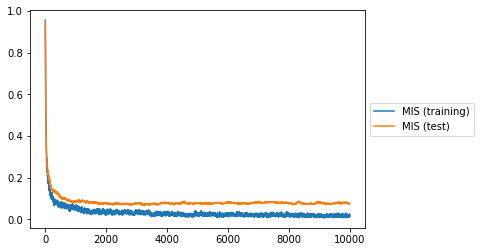

In [405]:
# plot MIS
plt.plot(train_mis)
plt.plot(test_mis)

plt.legend(['MIS (training)','MIS (test)'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

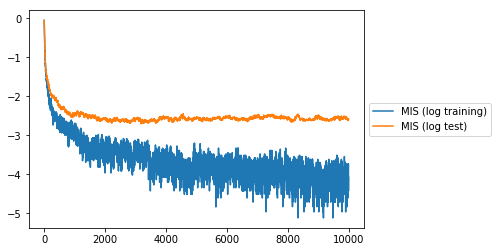

In [407]:
# plot MIS
plt.plot(np.log(train_mis))
plt.plot(np.log(test_mis))

plt.legend(['MIS (log training)','MIS (log test)'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()